### CT5133 Assignment 2: Transfer Learning, Convolutions, and Object Localisation in Keras

Aidan Tynan - 16394923           

Luke Hayes - 14498098

#### Import necessary libraries

In [1]:
#!pip install tensorflow
#!pip install keras

In [2]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from PIL import Image

# Part 1: Dataset

The dataset chosen for this assignment was sourced from a classification competition created by Professor Hyoseok Hwang for his deep learning class in South Korea. It was created to improve deep learning and pytorch coding skills for students in his class where they were asked to code a classifier using pytorch.

The dataset consists of images of 4 different animals with 900 training and 100 validation images for each animal. The animals in the dataset are: cheetahs, tigers, jaguars and hyenas. As this assignment only required two classes, cheetah and tiger images were chosen as the datasets to be used.

The images have a shape of (400,400,3) with those numbers being height, width and rgb/colour values respectively. These images have to be resized to (224,224,3) for our model implementation to process them. There is a small amount of pre-processing applied to the data which will be discussed in part two.


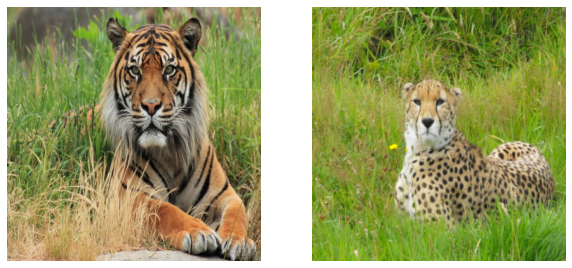

In [3]:
#Plot two example images
for i in range(1):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 2, 1)
    plt.imshow(Image.open('./validate/tiger_v/tiger_012_val_resized.jpg'))
    plt.axis("off")
    ax = plt.subplot(1, 2, 2)
    plt.imshow(Image.open('./validate/cheetah_v/cheetah_018_val_resized.jpg'))
    plt.axis("off")

## Import Datasets

In [4]:
training_dataset = tf.keras.preprocessing.image_dataset_from_directory('./train',image_size=(224,224), seed=42)

Found 1800 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory('./validate',image_size=(224,224),seed=42)

Found 200 files belonging to 2 classes.


## Plot example images with binary labels

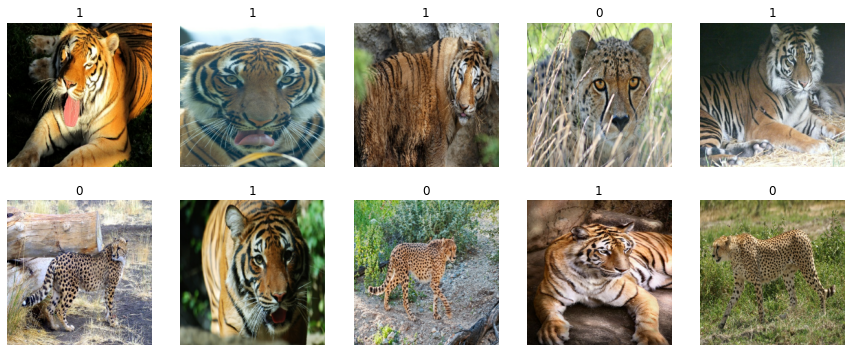

In [6]:
#Plot random example images from the resized dataset and title with their binary label, cheetah:(0), tiger:(1)
for image_demo in training_dataset.take(1):
    plt.figure(figsize=(15,6))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(np.array(image_demo[0][i]).astype(int))
        plt.title(int(image_demo[1][i]))
        plt.axis("off")

Link to the dataset: https://www.kaggle.com/iluvchicken/cheetah-jaguar-and-tiger

# Part 2: Transfer Learning

The pre-trained image classification model chosen for this assignment was MobileNetV2 as it is small and can load weights from the training already performed on the imagenet data. The dense classification head was removed by setting the include_top variable to false when importing the model.

A pre-processing layer was created to to randomly flip images horizontally and rotate or zoom them slightly. Basic data 
augmentation techniques that have been proven to improve deep learning image classifiers <b>[1].</b>
A Normalization layer was required to normalize the inputs from the pre-processing layer. It normalizes them using the mean and standard deviation to put the values in the range (-1,1). Once the inputs are normalized they are passed to the base layer of the MobileNetV2 model with imagenet weights. A globabl average pooling layer is then added before finally adding a dense layer with two neurons that uses the softmax activation function to predict the two classes.

The model is created below and then trained and evaluated. The base model is frozen so only the added layers will be trained.
A simple input layer was added to reshape the data before entering the model, as well as a GlobalAveragePooling 2D and a softmax activated dense layer to make the predictions on the class labels. These additions can be seen in the base model below.

## Generate Model

In [7]:
batch_size = 32
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3), #Height,Width,Colour
    include_top=False, # Exclude Dense Classification head
)  
#Set base model so layers can't be trained
base_model.trainable = False

#Shape inputs
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#Dense softmax activated output layer to make class predictions from pooling layer
outputs = keras.layers.Dense(2, activation="softmax")(x)
model_example = keras.Model(inputs, outputs)

print("Base Model with GlobalAveragePooling 2D and a softmax activated dense layer")
model_example.summary()

Base Model with GlobalAveragePooling 2D and a softmax activated dense layer
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


From the model summary the mobilenet model's output can be seen which has a shape of (None, 7, 7, 1280). These represent the batch size, the channel height, and width and the channel index. These channels are feature maps that result from the convolution layers, activation functions and reducing performed in the base mobilenet model. The feauture maps are used to detect features in the images to make predictions or to detect objects to be passed to a classifier.

After 1 epoch of training with the dataset split into 57 batches of 16 the base model showed an accuracy of 79.5% when evaluated on unseen data, there is a relatively high amount of loss when compared to the models that do have pre-processing and normalisation.

### Add pre-processing & normalisation

To improve the performance of the model a data augmentation pre-processing layer was added before the base model. This layer randomly flips images horizontally and has a chance to zoom and rotate them slightly. More importantly a normalisation layer was required to normalise the inputs and significantly increase the accuracy of the model. This normalisation layers performs root mean square error normalisation and allows for colour intensity reduction within images to keep the weights and biases from growing too large. This can also help the network learn faster since the data for each colour channel is centered around the zero mean which can cause the gradients to act more uniformly and potentially improve performance of the model. Normalisation is important to reduce the effect of outliers and can help reduce the impact of brightness for example when classifying objects in photos taken during the day and during the night.

In [8]:
batch_size = 32
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3), #Height,Width,Colour
    include_top=False, # Exclude Dense Classification head
)  
#Set base model so layers can't be trained
base_model.trainable = False

#Create a layer to randomly flip images or to rotate/zoom slightly
preprocessing_improvement = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

# Add layers to be trained
inputs = keras.Input(shape=(224, 224, 3))
x = preprocessing_improvement(inputs)  # Apply random data augmentation

#Need to add a normalizing layer to put inputs in the range (-1,1), (from (0,255))
#Without normalizing accuracy ~60-70% with normalizing its ~95-99%
##outputs = (inputs - mean) / sqrt(var)
normalization_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5]*3) #255/2
variance = mean * mean
x = normalization_layer(x)
normalization_layer.set_weights([mean, variance])

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,553
Trainable params: 2,562
Non-trainable params: 2,257,991
________________________________________

## Train Model

The model training consists of compiling the model and then fitting it to the data. The number of epochs can be altered to potentially imporve performance. The model iterates over the images in batches of 32 and updates its weights and parameters to improve the accuracy of calculations.

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
epochs = 2
model.fit(training_dataset, epochs=epochs)

Epoch 1/2
57/57 [==============================] - 75s 1s/step - loss: 0.3661 - sparse_categorical_accuracy: 0.9572
Epoch 2/2
57/57 [==============================] - 40s 697ms/step - loss: 0.3158 - sparse_categorical_accuracy: 1.0000


The model with pre-processing and data normalisation typically shows an accuracy over 97% after a single epoch and reductions in loss can be seen as the number of epochs increases up until the loss stabilizes.

## Evaluate Model on validation images

In [10]:
model.evaluate(validation_dataset)

7/7 [==============================] - 3s 443ms/step - loss: 0.3163 - sparse_categorical_accuracy: 1.0000


[0.3163098096847534, 1.0]

The base model without the added pre-processing layers or its dense classification head showed an accuracy of 79.5% but had a large loss value of 0.5319 indicating that its predictions aren't confident and it is likely to have a greater disparity between it's prediction and the target to be predicted.

When the normalisation was added however the accuracy increased significantly to ~99.5% and the loss decreased to 0.3196. This model performed substantially better due to the added layers. The reduction in loss is significant and indicates that the models predictions are smaller in variance and closer to the target to be predicted.

See below for example predictions.

    [Cheetah    Tiger]


C:\Users\aj\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


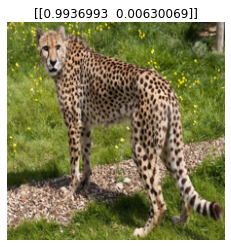

In [11]:
print("    [Cheetah    Tiger]")
for i in range(1):
    image = np.asarray(Image.open('./validate/cheetah_v/cheetah_001_val_resized.jpg').resize((224,224),3))
    cheetah_forPrediction = np.reshape(image,(1,image.shape[0],image.shape[1],image.shape[2]))
    title1 = model.predict(cheetah_forPrediction)
    plt.imshow(image)
    plt.title(title1)
    plt.axis("off")

     [Cheetah    Tiger]


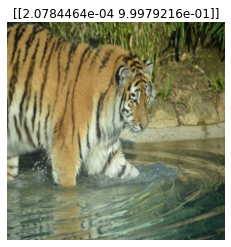

In [12]:
print("     [Cheetah    Tiger]")
for i in range(1):
    tiger = np.asarray(Image.open('./validate/tiger_v/tiger_007_val_resized.jpg').resize((224,224),3))
    tiger_forPrediction = np.reshape(tiger,(1,tiger.shape[0],tiger.shape[1],tiger.shape[2]))
    title2 = model.predict(tiger_forPrediction)
    plt.imshow(tiger)
    plt.title(title2)
    plt.axis("off")

# Part 3 Inspecting Convolutional Features

<b> Method </b>

In order to get the desired scalar output from each neuron we utilised Global Average Pooling. The aim of such a method is to reduce the risk of overfitting by reducing the total model parameters. It does so in this case by reducing the 7 x 7 x 1280 model to simply the number of dimensions which is 1280. This is done by simply taking the average of the 7 x 7 layer and thus reducing it to one singular value. Thus, we are left with a single value for each layer. In order to see what neurons have the most influence over the final predicted output, a softmax layer is used. This will give us a value for the importance of each neuron in the resulting decision. If we were to sum the values of all neurons together from this resulting softmax layer we would get a value of 1. This means tha in order to get the value for the most influential neurons in the decision we simply take the n highest values.

Using this information we simply created a function that would loop over the training images for both the cheetah and tiger classes and, using the model outlined above, create a array of values of influence for each nueuron in the classification of each image. From this resulting array we took the index of the 5 nurons with the largest influence on the output (5 with largest output values). Then to get the top 5 most interesting neurons for all of the cheetas and tigers we carried this out for each of the images in the training folder of each. A dictionary was created and if the neuron had already been added its values was incremented and if not the value was added as 1. This meant that after running the function on the cheetah test images the most interesting neurons could be evaluated accross the whole folder. The top 5 were then taken for both the cheetah and tiger results

<b> Results </b>

Here are the results for the cheetah training data (key, value):

Cheetah Dictionary Results (522: 854), (1241: 514), (587: 191), (511: 176), (90: 163)

This means that the neuron 522 was the most influential as it appeared 854 times out of the 900 images. The 1241 neuron also appeared to be very popular appearing in the top 5 514 times. The neurons 587, 511 and 90 occured much less but still made the top 5 a significant number of times. 
Here are the results for the tiger training data (key, value):

Tiger Dictionary Results (522: 843), (1241: 429), (587: 423), (511: 275), (54: 237)

Interestingly here the results are very similar to that of the cheetah results with the 4/5 neurons being in the same position of importance. This is quite shocking and therefore the model is very reliant on these neurons for classification. The 522 neuron is clearly the most influential in the tiger data as it was in the cheetah data. Neuron 1241 is sligtly less important that in the cheetah training data but is still highly important. The next two neurons 587 and 511 are then in the top 5 on a much more frequent basis than in the cheetah data and finally the neuron 54 makes it in the top 5 in the place of the 90 neuron. This illustrates that the model does use different neurons to classify cheetas over tigers. The heavy reliance on these 4 neurons however could be a sign of overfitting and perhaps dropout would be an approach to rectify this. Dropout is a process of removing neurons when training in order to reduce overreliance on these neurons and this may help in this context. 



In [13]:
#Base model with global pooling and a softmax layer.
global_pooling = keras.layers.GlobalAveragePooling2D()
softmax_layer = keras.layers.Softmax()
neuronSearch = keras.Sequential(
    [
        base_model,
        global_pooling,
        softmax_layer        
    ]
)
neuronSearch.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
softmax (Softmax)            (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
import os
notebook_path = os.path.abspath("DeepLearningAssignment2.ipynb")

In [15]:
#function that takes in an image or set of images
#extracts the top 3 neurons by taking neurons with the highest softmax value and adding them to a dictionary
#the neurons with the highest activation count over all the images are taken 
def interesting_neurons(animal, N):
    
    #file path depends on the animal 
    if animal == "cheetah":
        path = './train/cheetah/'
    elif animal == "tiger":
        path = './train/tiger/'
    #blank dict to add neurons to.
    neuron_dict = {}
    
    for filename in os.listdir(path):
        #Open and resize image
        image = np.asarray(Image.open(path + filename).resize((224,224),3))
        #reshape into a single batch for prediction
        img_forPrediction = np.reshape(image,(1,image.shape[0],image.shape[1],image.shape[2]))
        #Get the prediction from the model
        img_array = neuronSearch.predict(img_forPrediction)
        #take the top N neurons
        neurons = sorted(range(len(img_array[0])), key = lambda sub: img_array[0][sub])[-N:]
        
        #Add top N neurons to dict or increment their count if they're already there
        for neur in neurons:
            if neur in neuron_dict:
                neuron_dict[neur] += 1
            else:
                neuron_dict[neur] = 1
                
    #Return the dict
    return neuron_dict
        
#Run the function above on cheetah/tiger training set to see which neurons/channels appear in the top 3 for all images       
cheetah_dict = interesting_neurons("cheetah", 3)       
tiger_dict = interesting_neurons("tiger", 3)

#Extract the top 5
cheetah_keys = sorted(cheetah_dict, key=cheetah_dict.get, reverse=True)[:5]
tiger_keys = sorted(tiger_dict, key=tiger_dict.get, reverse=True)[:5]


print(cheetah_keys)
print(tiger_keys)


[522, 1241, 587, 511, 90]
[522, 1241, 587, 511, 54]


In [16]:
#cheetah_dict 
#Neurons and their counts of being in the softmax top 3 for all 900 images of the training dataset
# (522: 854), (1241: 514), (587: 191), (511: 176), (90: 163)
# ~95%, 57%, 21%, 19.5%, 18%

#tiger_dict
#Neurons and their counts of being in the softmax top 3 for all 900 images of the training dataset
# (522: 843), (1241: 429), (587: 423), (511: 275), (54: 237)
# 94%, 47%, 47%, 30%, 26%

# Part 4: Object Localization

<b> Object Localization </b>

When looking at this concept it is important to emphasize that this task could simply be carried out by attempting to locate the object such as a tiger or it could also be split into identifying several more complex features such as the eyes. This therefore means that when analysing the suitability of each layer for localization we must analyse exactly what features the layer is looking at. For out localization system we have chosen to select the output base model layer which is 7 x 7 x 1280 in size. Therefore, we are looking at each of the interesting channels in part 3 individually meaning we are analysing the 7 x 7 grid output. This output is essentially a heatmap highlighting the main focus areas of that specific layer. The aim here is to use these outputs for each layer accross a number of images to analyse that layers suitability of use for the localization of objects in the input image. When analysing what features individual layers could be looking at it is important to note what are the features that diffrentiate a tiger from a cheetah. There are large differences in facial features such as the face shape, the nose, the eyes, the ears and the stripes and hair on the face. There is also a big difference in the stripes that the tiger has and the spots the cheetah has. The cheetah also has a much leaner body in comparison to the bulkier body of the tiger. These are all individual features that each layer could be using as a means of diffrentiating between the tiger and the cheetah and since we are using the final layer of the model, we can be certain that these are the types of features being looked at. The following section of analysis is carried out with both the tiger and cheetah channel figures below.


<b> Channel Analysis </b>

<b> 511 </b>

From the areas highlighted in the resulting images from the 511 channel it appears as though this channel is aiming to diffrentiate between the tigers and cheetah by looking for areas with stripes or spots. This means that the exact location of analysis can vary from image to image. In one image the tail may be analysed and another the face may be analysed. This means that this layer could in fact be used in conjuction of other layers to localize the entire object. However, this could not be used for example in localizing the animals face as the layer may be focusing on the tail. This makes the layer somewhat useful in the task of localization.


<b> 522 </b>

This channel appears to be highly useful in aiming to localize the entire animal as it focussed on all areas that the animal is present. This means that this layers output could be fed to another layer as a region of proposal similar to that of the YOLO algorithm. This could then simply draw a bounding box around the proposed area and it would appear that it would capture the the animal perfectly. 


<b> 1241 </b>

This layer is very similar to 522 except for the fact that it appears to miss some small key parts of the animal such as the face or feet. This means that it could be utilised in conjenction with layers that look at these missing features in order to capture accurate localization of the animal. The output of these combined results could be fed to an algorithm that would draw a bounding box around the proposed region which would lead to correct localization of the animal.


<b> 587 </b>

This layer appears to be much better suited to discenring features of the tiger which makes sense considering it activates twice as much for tiger pictures than cheetah pictures as observed in part 3. The channel manages to capture the features of the tiger well and this information could be used in conjuction with another model to draw bouding boxes in order to localize the entire animal.


<b> 90 </b>

This channel is used heavily in cheetah classification but not used as much in tiger classification. Therefore such a channel can be assumed to be looking at featres unique to the cheetah. We can again assume that this channel is looking for spots as it is focused mainly on the areas where spots are located on the cheetah. This again means it could be used in conjection with other layers to localize cheetahs. As said before while this layer does focus on areas of the cheetah, this area changes depending on the image. This makes this layer much less useful in the task of localization.


<b> 54 </b>

This channel is used frequently as a means of classifying tigers and not used as frequently as much to classify cheetahs. This means we can therefore assume this layer is looking for features unique to the tiger. This feature map manages to capture the areas of the image that the tiger is present in well. As explained above, through the use of many feature maps or channels, key features of an object or class can be observed and supplemented with other features and/or models can be used to localise objects.

## Visualize and superimpose channel outputs

In [17]:
def superimposeImage(string,image_orig,channels, predictionTensor):
    plt.figure(figsize=(18,10))
    for i in range(len(channels)):
        plt.imsave(string, predictionTensor[0,:,:,channels[i]])
        image = Image.open(string).resize((224,224),3)
        image = image.convert("RGB")
        new_img = Image.blend(image_orig, image, 0.5)
        ax = plt.subplot(1,len(channels),i+1)
        ax.set_title(channels[i])
        plt.imshow(new_img)
        plt.axis("off")
        

In [18]:
def createHeatmaps(img,channels):
    img_1 = np.asarray(img)
    forPrediction = np.reshape(img_1,(1,img_1.shape[0],img_1.shape[1],img_1.shape[2]))
    tensor1 = base_model.predict(forPrediction)
    superimposeImage("tiger1.png",img,channels,tensor1)

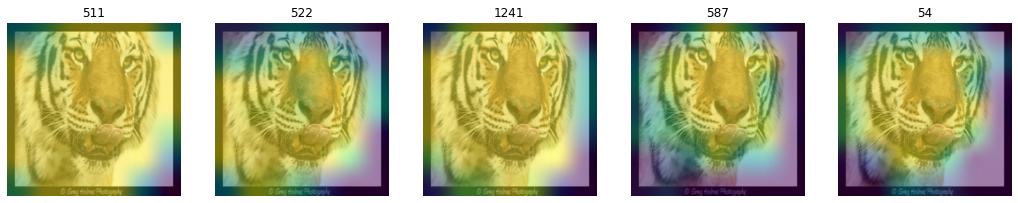

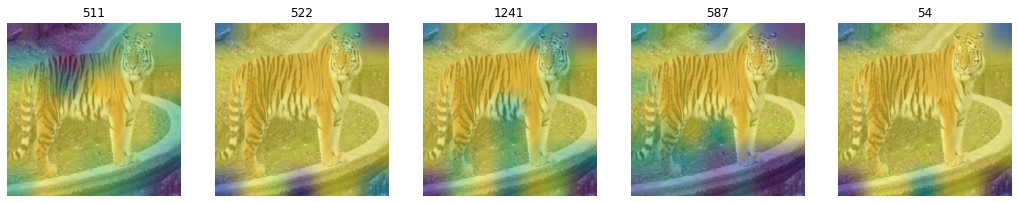

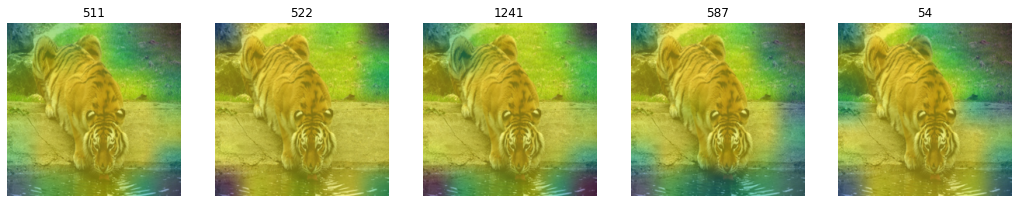

In [19]:
channels = [511,522,1241,587,54]
tiger1 = Image.open('./validate/tiger_v/tiger_005_val_resized.jpg').resize((224,224),3)
tiger2 = Image.open('./validate/tiger_v/tiger_000_val_resized.jpg').resize((224,224),3)
tiger3 = Image.open('./validate/tiger_v/tiger_014_val_resized.jpg').resize((224,224),3)
createHeatmaps(tiger1,channels)
createHeatmaps(tiger2,channels)
createHeatmaps(tiger3,channels)

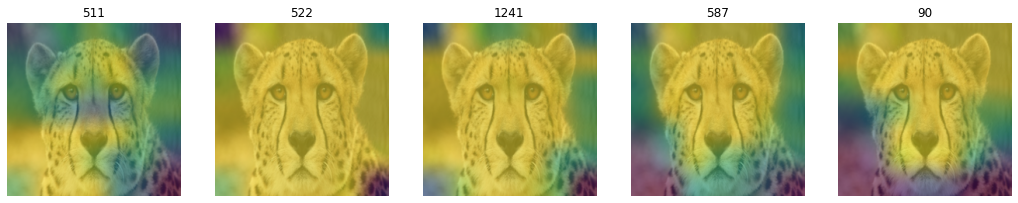

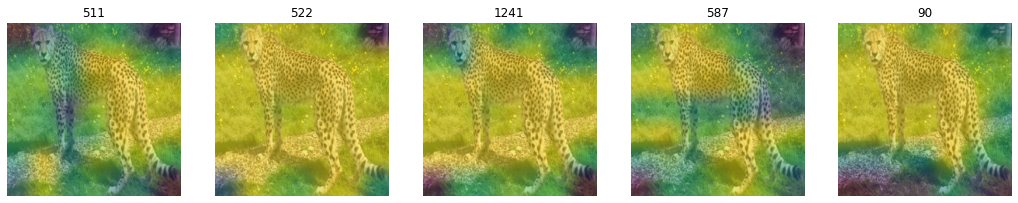

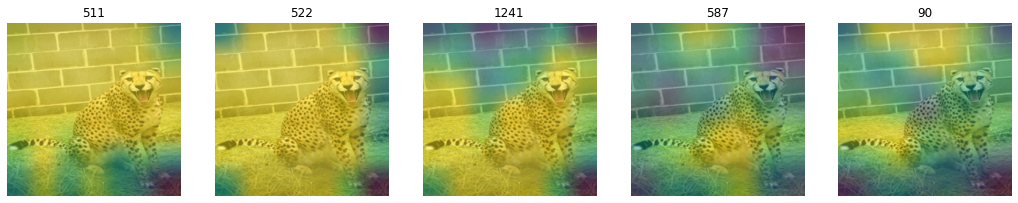

In [20]:
channels = [511,522,1241,587,90]
cheetah1 = Image.open('./validate/cheetah_v/cheetah_007_val_resized.jpg').resize((224,224),3)
cheetah2 = Image.open('./validate/cheetah_v/cheetah_001_val_resized.jpg').resize((224,224),3)
cheetah3 = Image.open('./validate/cheetah_v/cheetah_015_val_resized.jpg').resize((224,224),3)
createHeatmaps(cheetah1,channels)
createHeatmaps(cheetah2,channels)
createHeatmaps(cheetah3,channels)

<b>[1]</b>  Shorten, C., Khoshgoftaar, T.M. A survey on Image Data Augmentation for Deep Learning. J Big Data 6, 60 (2019). 
https://doi.org/10.1186/s40537-019-0197-0